In [1]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 663 kB 26.3 MB/s 


In [ ]:
# Use Hardware accelerators for training
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("GPU Available :",physical_devices)
# tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
# For Colab TPU

#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

## Download Dataset

In [2]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR),"ModelNet10")

473402300/473402300 [==============================] - 38s 0us/step


In [3]:
!ls $DATA_DIR/monitor/test

monitor_0466.off  monitor_0491.off  monitor_0516.off  monitor_0541.off
monitor_0467.off  monitor_0492.off  monitor_0517.off  monitor_0542.off
monitor_0468.off  monitor_0493.off  monitor_0518.off  monitor_0543.off
monitor_0469.off  monitor_0494.off  monitor_0519.off  monitor_0544.off
monitor_0470.off  monitor_0495.off  monitor_0520.off  monitor_0545.off
monitor_0471.off  monitor_0496.off  monitor_0521.off  monitor_0546.off
monitor_0472.off  monitor_0497.off  monitor_0522.off  monitor_0547.off
monitor_0473.off  monitor_0498.off  monitor_0523.off  monitor_0548.off
monitor_0474.off  monitor_0499.off  monitor_0524.off  monitor_0549.off
monitor_0475.off  monitor_0500.off  monitor_0525.off  monitor_0550.off
monitor_0476.off  monitor_0501.off  monitor_0526.off  monitor_0551.off
monitor_0477.off  monitor_0502.off  monitor_0527.off  monitor_0552.off
monitor_0478.off  monitor_0503.off  monitor_0528.off  monitor_0553.off
monitor_0479.off  monitor_0504.off  monitor_0529.off  monitor_0554.off
monito

### Visualize a Mesh from the Dataset

In [4]:
# OFF (Object File Format) is a geometry definition file format containing 
#the description of the composing polygons of a geometric object.
#It can store 2D or 3D objects, and simple extensions allow it to represent higher-dimensional objects as well.
mesh = trimesh.load(os.path.join(DATA_DIR,"chair/train/chair_0001.off"))
mesh.show()

In [5]:
mesh1 = trimesh.load(os.path.join(DATA_DIR,"monitor/test/monitor_0491.off"))
mesh1.show()

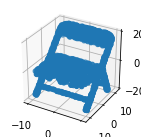

In [6]:
# https://stackoverflow.com/questions/3584805/what-does-the-argument-mean-in-fig-add-subplot111
points = mesh.sample(2048)  # 2048 data points
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(221,projection="3d")
ax.scatter(points[:,0],points[:,1],points[:,2])
# ax.set_axis_off()
plt.show()

### Sample a Mesh and Show Results

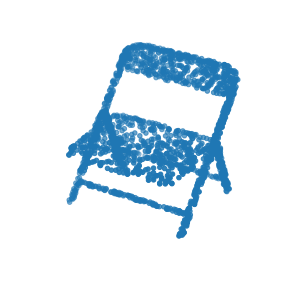

In [7]:
points = mesh.sample(2048)  # 2048 data points
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_axis_off()
plt.show()

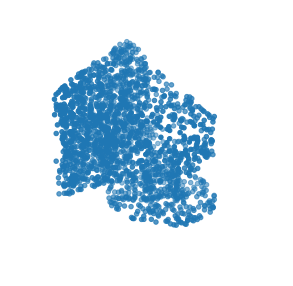

In [8]:
points = mesh1.sample(2048)  # 2048 data points
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_axis_off()
plt.show()

In [9]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [10]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: toilet
processing class: night_stand
processing class: dresser
processing class: sofa
processing class: monitor
processing class: table
processing class: bed
processing class: chair
processing class: bathtub
processing class: desk


In [11]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

### Build a model

In [12]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [14]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

### Build & Summarize the model architecture

In [15]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

### Train Model

In [ ]:
# # Compile model with TPU strategy
# with strategy.scope():
model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      metrics=["sparse_categorical_accuracy"],
    )
# model.fit(train_dataset, epochs=20, validation_data=test_dataset)
model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 24s 156ms/step - loss: 3.1678 - sparse_categorical_accuracy: 0.3698 - val_loss: 198824198144.0000 - val_sparse_categorical_accuracy: 0.2687
Epoch 2/20
125/125 [==============================] - 19s 151ms/step - loss: 2.8590 - sparse_categorical_accuracy: 0.4425 - val_loss: 51016420405805056.0000 - val_sparse_categorical_accuracy: 0.3480
Epoch 3/20
125/125 [==============================] - 19s 152ms/step - loss: 2.6420 - sparse_categorical_accuracy: 0.5152 - val_loss: 16810889617342464.0000 - val_sparse_categorical_accuracy: 0.5055
Epoch 4/20
125/125 [==============================] - 19s 153ms/step - loss: 2.5156 - sparse_categorical_accuracy: 0.5440 - val_loss: 416575193088.0000 - val_sparse_categorical_accuracy: 0.6079
Epoch 5/20
125/125 [==============================] - 19s 152ms/step - loss: 2.3624 - sparse_categorical_accuracy: 0.5856 - val_loss: 28786589696.0000 - val_sparse_categorical_accuracy: 0.5231
Epoch 6/20
125/125 [=

### Visualize Predictions

1/1 [==============================] - 1s 1s/step


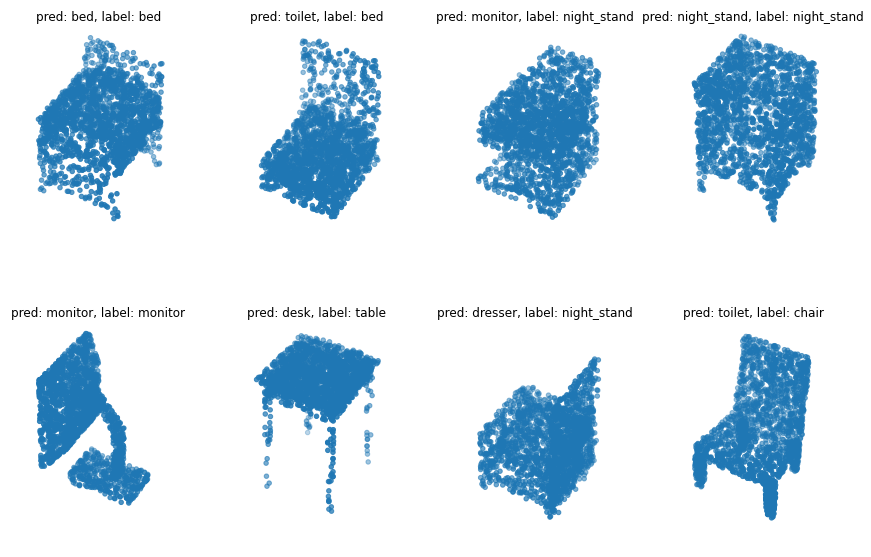

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

### Save Model

In [ ]:
# !mkdir -p pointcloud/modelv1
# model.save('pointcloud/modelv1')

# PointCloud Classification using PointNet references
⚓ https://www.youtube.com/watch?v=GGxpqfTvE8c

⚓ https://keras.io/examples/vision/pointnet/

⚓ https://github.com/charlesq34/pointnet 